# YOLO

This notebook is an implementation of [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/pdf/1506.02640.pdf) by Redmon et al. Just like the original paper, we used image recognition model pretrained on [ImageNet dataset](https://www.image-net.org/) and adapted it to [VOC 2007 dataset](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/index.html), which is a relatively small dataset and saves a lot of training time.

We first need to install and import all the requirements for training. In this notebook, we use TensorFlow as the backbone of the model.

In [1]:
# For pip users
# ! pip install -r ../requirements.txt
# For conda users
! conda install --file ../requirements.txt -y

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import *
import numpy as np
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from augment import Augment
from base_model import base_model
from learning_schedule import LearningSchedule
from sum_squared_loss import SumSquaredLoss

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config = config)

# ms = tf.distribute.MirroredStrategy()
# num_devices = ms.num_replicas_in_sync
# print('Number of devices: {}'.format(num_devices))

Solving environment: done

# All requested packages already installed.



2022-04-30 15:12:22.157804: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10795 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0035:03:00.0, compute capability: 7.0


Then we acquire the VOC dataset for training from TensorFlow datasets. We then perform a series of mappings to throw away unimportant data. Firstly, we resize the image to $448 \times 448$ so that every single image in the dataset has the same size. After that, we extract bounding box and labels from original training labels and pad them to a length of 50 so that they can be batched and thus improve the training time.

2022-04-30 15:12:22.188655: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10795 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0035:03:00.0, compute capability: 7.0


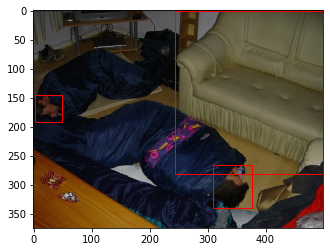

In [2]:
train_ds, val_ds, test_ds = tfds.load("voc", split = ["train", "validation", "test"], shuffle_files = True)

batch_size = 41
global_batch_size = batch_size * 1

for sample in train_ds.take(1):
    x, bbox = sample["image"], sample["objects"]["bbox"]
    fig, ax = plt.subplots()
    ax.imshow(x)
    h, w, _ = x.shape

    for b in bbox:
        ax.add_patch(patch.Rectangle((b[1] * w, b[0] * h), (b[3] - b[1]) * w, (b[2] - b[0]) * h, linewidth = 1, edgecolor='r', facecolor='none'))
    plt.show()

Resizing = tf.keras.layers.Resizing(448, 448)

train_ds = train_ds.map(lambda data: (data["image"], data["objects"]))
train_ds = train_ds.map(lambda x, y: (Resizing(x), (tf.cast(y["bbox"], tf.float64), y["label"], tf.shape(y["label"])[0])))
train_ds = train_ds.padded_batch(global_batch_size)

val_ds = val_ds.map(lambda data: (data["image"], data["objects"]))
val_ds = val_ds.map(lambda x, y: (Resizing(x), (tf.cast(y["bbox"], tf.float64), y["label"], tf.shape(y["label"])[0])))
val_ds = val_ds.padded_batch(global_batch_size)

test_ds = test_ds.map(lambda data: (data["image"], data["objects"]))
test_ds = test_ds.map(lambda x, y: (Resizing(x), (tf.cast(y["bbox"], tf.float64), y["label"], tf.shape(y["label"])[0])))
test_ds = test_ds.padded_batch(global_batch_size)

# train_dist_ds = ms.experimental_distribute_dataset(train_ds)
# val_dist_ds = ms.experimental_distribute_dataset(val_ds)
# test_dist_ds = ms.experimental_distribute_dataset(test_ds)

Here we define our target loss. The sum squared loss here is identical with the original paper, but we iterate over all the bounding boxes in the label instead of through all the grids to improve training time. The loss purposed in the paper is below:

![image.png](attachment:f3cc9170-f943-45f5-ae30-0d7e57ca01fb.png)

We then define our YOLO model. Instead of GoogLeNet-like structure purposed in the paper, we use ResNet-50 as our base model. We then put the output from ResNet to a sequence of dense layers, getting an output of size $7 \times 7 \times 30$.

In [8]:
class YOLO(tf.keras.Model):
    def __init__(self, weight_decay, dropout_rate):
        super().__init__()
        
        self.augment = Augment()
#         self.base_model = base_model(weight_decay, dropout_rate)
        self.base_model = tf.keras.applications.resnet50.ResNet50(include_top = False, input_shape = (448, 448, 3), 
                                                                  pooling = "avg")
        self.base_model.trainable = False;
        self.base_model.trainable = False
        self.weight_decay = weight_decay
        self.dropout_rate = dropout_rate
        self.dense = Dense(units = 4096, kernel_regularizer = l2(weight_decay))
        self.bn = BatchNormalization()
        self.activation = LeakyReLU(.1)
        self.dropout = Dropout(dropout_rate)
        self.out = Dense(units = 7 * 7 * 30, activation = "linear")
        self.loss_function = SumSquaredLoss()
    
    def call(self, inputs, training = False):
#         x = self.augment(inputs)
        x = self.base_model(inputs)
        x = self.dense(x)
        x = self.bn(x)
        x = self.activation(x)
        x = self.dropout(x)
        output = self.out(x)
        
        return output
    
    def evaluate(self, x, y, batch_size=None, verbose=1, sample_weight=None, steps = None, 
                 callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False,
                 return_dict=False, **kwargs):
        loss = 0
        size = 0
        
        for batch_x, batch_y in x:
            batch_loss = self._tf_evaluate(batch_x, batch_y)
            loss += batch_loss
            size += 1
        
        return {"loss": loss / size}
    
    @tf.function(input_signature=[tf.TensorSpec(dtype=tf.float32, shape=[None, None, None, 3]),
                                 (tf.TensorSpec(dtype=tf.float64, shape=[None, None, 4]),
                                 tf.TensorSpec(dtype=tf.int64, shape=[None, None, ]),
                                 tf.TensorSpec(dtype=tf.int32, shape=[None, ]))])
    def _tf_evaluate(self, x, y):
        output = self.call(x)

        return self.loss_function(y, output)
    
    def train_step(self, data):
        return self._tf_train_step(data)

    @tf.function(input_signature=[[tf.TensorSpec(dtype=tf.float32, shape=[None, None, None, 3]),
                                 (tf.TensorSpec(dtype=tf.float64, shape=[None, None, 4]),
                                 tf.TensorSpec(dtype=tf.int64, shape=[None, None, ]),
                                 tf.TensorSpec(dtype=tf.int32, shape=[None, ]))]])
    def _tf_train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            output = self.call(x)
            loss = self.loss_function(y, output)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
  
        return {"loss": loss}

Finally, we train our YOLO model on the dataset. We decide to use a smaller learning rate compared to the original one and trained the model over 100 epochs. We also plot the training process regarding training loss at each step.

Epoch 1/10
61/61 [==============================] - 83s 1s/step - loss: 348.2170 - val_loss: 230.6443
Epoch 2/10
61/61 [==============================] - 74s 1s/step - loss: 175.9477 - val_loss: 188.1346
Epoch 3/10
61/61 [==============================] - 73s 1s/step - loss: 137.1447 - val_loss: 168.8646
Epoch 4/10
61/61 [==============================] - 73s 1s/step - loss: 124.2379 - val_loss: 167.9938
Epoch 5/10
61/61 [==============================] - 73s 1s/step - loss: 119.6962 - val_loss: 160.7121
Epoch 6/10
61/61 [==============================] - 73s 1s/step - loss: 95.4338 - val_loss: 157.7485
Epoch 7/10
61/61 [==============================] - 73s 1s/step - loss: 87.0120 - val_loss: 157.9223
Epoch 8/10
61/61 [==============================] - 74s 1s/step - loss: 84.3095 - val_loss: 159.0058
Epoch 9/10
61/61 [==============================] - 73s 1s/step - loss: 91.0938 - val_loss: 150.5895
Epoch 10/10
61/61 [==============================] - 74s 1s/step - loss: 79.3067 - val

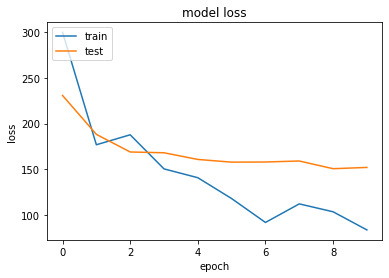

In [9]:
weight_decay = [1, .1, 1e-2, 1e-3, 1e-4]
dropout_rate = [.3, .5, .7]

cp = tf.keras.callbacks.ModelCheckpoint("weights", monitor = "val_loss", verbose = 0, save_best_only = True, mode = "auto")

# for wd in weight_decay:
#     for dr in dropout_rate:
wd = 1e-3
dr = .5
model = YOLO(wd, dr)

model.compile(tf.keras.optimizers.Adam(learning_rate = 1e-4))
# model.compute_output_shape(input_shape = (None, 448, 448, 3))

# model.load_weights("weights")

history = model.fit(train_ds, validation_data = val_ds, epochs = 10, callbacks = [])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

for i, (iou, val_iou) in enumerate(zip(history.history['loss'], history.history['val_loss'])):
    if (i + 1) % 10 == 0:
        plt.annotate("{:.2f}".format(iou), xy = (i + 1, iou))
        plt.annotate("{:.2f}".format(val_iou), xy = (i + 1, val_iou))

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.savefig("wd=" + str(wd) + " dr=" + str(dr) + ".jpg")
plt.show()

Here we show the result of our model by plotting the original labels and our predictions side by side.

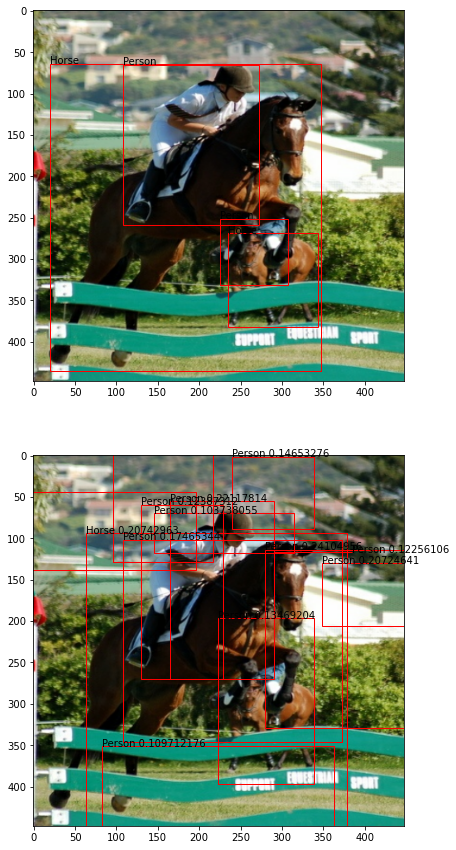

In [12]:
labels = [
          "Aeroplane",
          "Bicycle",
          "Bird",
          "Boat",
          "Bottle",
          "Bus",
          "Car",
          "Cat",
          "Chair",
          "Cow",
          "Dining Table",
          "Dog",
          "Horse",
          "Motorbike",
          "Person",
          "Potted Plant",
          "Sheep",
          "Sofa",
          "Train",
          "TV/Monitor"
]


for sample_x, sample_y in train_ds.take(1):
    output = model.call(tf.expand_dims(sample_x[0], axis = 0))
    sample_bbox, sample_y, size = sample_y
    
#     print(mAP()((tf.expand_dims(sample_bbox[0], axis = 0), tf.expand_dims(sample_y[0], axis = 0), 
#                  tf.expand_dims(size[0], axis = 0)), output))
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (15, 15))
    img_h, img_w, _ = sample_x[0].shape

    ax1.imshow(tf.cast(sample_x[0], tf.int64))
    
    for b, y in zip(sample_bbox[0], sample_y[0]):
        if b[0] == 0: 
            continue
            
        ax1.add_patch(patch.Rectangle((b[1] * img_w, b[0] * img_h), (b[3] - b[1]) * img_w, 
                                      (b[2] - b[0]) * img_h, linewidth = 1, edgecolor='r', facecolor='none'))
        ax1.annotate(labels[y], (b[1] * img_w, b[0] * img_h))

    sample_pred = model.predict(np.expand_dims(Resizing(sample_x[0]), axis = 0)).reshape(7, 7, 30)
    
    ax2.imshow(tf.cast(sample_x[0], tf.int64))
    for i in range(7):
        for j in range(7):
            max_idx = sample_pred[i, j, 9] > sample_pred[i, j, 4]

            if sample_pred[i, j, max_idx * 5 + 4] * np.max(sample_pred[i, j, 10:]) >= 0.1:
                cx = sample_pred[i, j, max_idx * 5]
                cy = sample_pred[i, j, max_idx * 5 + 1]
                w = sample_pred[i, j, max_idx * 5 + 2]
                h = sample_pred[i, j, max_idx * 5 + 3]

                ax2.add_patch(patch.Rectangle((img_w / 7 * (cx + i) - w * img_w / 2, img_h / 7 * (cy + j) - h * img_h / 2), 
                                              img_w * w , img_h * h, linewidth = 1, edgecolor='r', facecolor='none'))
                ax2.annotate(labels[np.argmax(sample_pred[i, j, 10:])] + " " + 
                             str(sample_pred[i, j, max_idx * 5 + 4] * np.max(sample_pred[i, j, 10:])), 
                             (img_w / 7 * (cx + i) - w * img_w / 2, img_h / 7 * (cy + j) - h * img_h / 2))
    

    plt.show()

In [ ]:
# Unfinished part

class mAP(tf.keras.metrics.Metric):
    def __init__(self):
        super(mAP, self).__init__(name = "mAP")
        # mAP
        self.mean_average_precision = tf.Variable(0.0, dtype = tf.float64, trainable = False)

        # Total # of data
        self.total = tf.Variable(0, dtype = tf.float64, trainable = False)
        
        # True positve [label, threshold = [0, 1]]
        self.tp = tf.Variable(tf.zeros((20, 11), dtype = tf.float64), trainable = False)
        
        # True positive + False negative [label]
        self.tp_fn = tf.Variable(tf.zeros(20, dtype = tf.float64), trainable = False)
        
        # True positive + False postivie [label, threshold = [0, 1)]
        self.tp_fp = tf.Variable(tf.zeros((20, 10), dtype = tf.float64), trainable = False)

        # Precision [threshold = [0, 1)]
        self.precision = tf.Variable(tf.zeros(10, dtype = tf.float64), trainable = False)

        # Recall [threshold = [0, 1]]
        self.recall = tf.Variable(tf.zeros(11, dtype = tf.float64), trainable = False)

        # Confidence score by label [label, bbox = [(0, 0), (6, 6)]] = pr(label) * confidence_score(bbox)
        self.cscore = tf.Variable(tf.zeros((20, 7, 7), dtype = tf.float64), trainable = False)
    
    def update_state(self, y_true, y_pred, sample_weight = None):
        y_pred = tf.cast(tf.reshape(y_pred, (tf.shape(y_pred)[0], 7, 7, 30)), dtype = tf.float64)
        (bbox, label, size) = y_true
        self.total.assign_add(tf.cast(tf.shape(y_pred)[0], tf.float64))
    
        for i in tf.range(tf.shape(y_pred)[0]):
            # Initialization
            self.tp.assign(tf.zeros((20, 11), dtype = tf.float64))
            self.tp_fn.assign(tf.zeros(20, dtype = tf.float64))
            self.tp_fp.assign(tf.zeros((20, 10), dtype = tf.float64))

            for ll in range(20):
                self.cscore[ll, :, :].assign(y_pred[i, :, :, 10 + ll] * tf.maximum(y_pred[i, :, :, 4], y_pred[i, :, :, 9]))

            for j in tf.range(size[i]):
                b, l = bbox[i, j], label[i, j]

                cx_real = (b[1] + b[3]) / 2
                cy_real = (b[0] + b[2]) / 2

                grid_x = tf.cast(cx_real * 7, tf.int64)
                grid_y = tf.cast(cy_real * 7, tf.int64)

                self.tp_fn[l].assign(self.tp_fn[l] + 1)
                
                thres = tf.cast(tf.clip_by_value(self.cscore[l, grid_x, grid_y] * 10, 0, 10), tf.int64)
                
                self.tp[l, :thres + 1].assign(self.tp[l, :thres + 1] + tf.ones(thres + 1, tf.float64))

            sum_label = tf.constant(0, dtype = tf.float64)
            sample_map = tf.constant(0, dtype = tf.float64)

            for thres in range(10):
                self.tp_fp[:, thres].assign(tf.reduce_sum(tf.cast(self.cscore >= thres / 10, tf.float64), axis = (1, 2)))

            for l in range(20):
                if self.tp_fn[l] != 0:
                    sum_label += 1

                    confs = y_pred[i, :, :, l + 10] * tf.maximum(y_pred[i, :, :, 4], y_pred[i, :, :, 4])

                    self.precision.assign(tf.math.divide_no_nan(self.tp[l, :-1], self.tp_fp[l]))
                    self.precision[-1].assign(1)

                    self.recall.assign(tf.math.divide_no_nan(self.tp[l], self.tp_fn[l]))
                    self.recall[-1].assign(0)

                    sample_map += tf.reduce_sum((self.recall[:-1] - self.recall[1:]) * self.precision)
                    
                    print(self.recall, self.precision)

            self.mean_average_precision.assign_add(sample_map / sum_label)
    
    def result(self):
        return self.mean_average_precision / self.total
    
    def reset_state(self):
        self.mean_average_precision.assign(0)
        self.total.assign(0)